In [1]:
import os
import sys
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import mne

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, find_nearest_ind

In [4]:
%matplotlib qt

### Get meta data from files

In [5]:
data_folder = r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse569069\estim_vis2_2021-03-12_10-52-44\experiment1\recording1'
exp = EEGexp(data_folder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation


In [6]:
print(exp.mouse)
print(exp.date)
print(exp.experiment_type)
print(exp.computerID)
print(exp.ephys_params['EEG']['sample_rate'])

569069
2021-03-12 10:52:44
electrical and sensory stimulation
W10DT05491
2500


### Use EEGexp function to load data. Array returned is already remapped into EEG array ch numbers (ch 31 & 32 should be very noisy). Data is in microvolts.

In [7]:
eegdata, eegtimestamps = exp.load_eegdata()

In [8]:
print(eegdata.shape)

(21768448, 30)


### Create MNE Raw object

In [9]:
ch_list = np.arange(0, 30)
ch_names = [str(x) for x in ch_list]

info = mne.create_info(ch_names=ch_names, sfreq=exp.ephys_params['EEG']['sample_rate'], ch_types='eeg')
# can add bad channels to info

In [10]:
mne_raw = mne.io.RawArray(eegdata.T[ch_list,:]*1e-6, info)
# for mne.io.RawArray, eeg channels must be in Volts

Creating RawArray with float64 data, n_channels=30, n_times=21768448
    Range : 0 ... 21768447 =      0.000 ...  8707.379 secs
Ready.


In [11]:
scalings = {'eeg': 100e-6}

Plotting appears to be working. Should double check the scale bar at some point, but looks close enough.

### Create "events" array to make Epochs

From mne docs (https://mne.tools/stable/auto_tutorials/simulation/plot_creating_data_structures.html#tut-creating-data-structures):
<br>*It is necessary to supply an “events” array in order to create an Epochs object. This is of shape(n_events, 3) where the first column is the sample number (time) of the event, the second column indicates the value from which the transition is made from (only used when the new value is bigger than the old one), and the third column is the new event value.*

In [12]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep
0,biphasic,40,314.33655,314.33695,0.0004,0
1,biphasic,20,317.86957,317.86997,0.0004,0
2,biphasic,40,321.93120,321.93160,0.0004,0
3,biphasic,70,326.31348,326.31389,0.0004,0
4,biphasic,70,330.48309,330.48349,0.0004,0


In [13]:
stim_log['event_descriptor'] = stim_log.apply(lambda row: row.stim_type + '_' + str(row.parameter) + '_' + str(row.sweep), axis = 1)
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,event_descriptor
0,biphasic,40,314.33655,314.33695,0.0004,0,biphasic_40_0
1,biphasic,20,317.86957,317.86997,0.0004,0,biphasic_20_0
2,biphasic,40,321.93120,321.93160,0.0004,0,biphasic_40_0
3,biphasic,70,326.31348,326.31389,0.0004,0,biphasic_70_0
4,biphasic,70,330.48309,330.48349,0.0004,0,biphasic_70_0


In [14]:
event_id_dict = {key: i for i, key in enumerate(stim_log.event_descriptor.unique())} 
print(event_id_dict) 

{'biphasic_40_0': 0, 'biphasic_20_0': 1, 'biphasic_70_0': 2, 'circle_white_0': 3, 'biphasic_40_1': 4, 'biphasic_20_1': 5, 'biphasic_70_1': 6, 'circle_white_1': 7, 'biphasic_40_2': 8, 'biphasic_20_2': 9, 'biphasic_70_2': 10, 'circle_white_2': 11, 'biphasic_40_3': 12, 'biphasic_20_3': 13, 'biphasic_70_3': 14}


In [15]:
event_onset_times = stim_log['onset'].to_numpy()
event_descriptors = stim_log['event_descriptor'].to_numpy()

event_onset_inds = np.array([find_nearest_ind(eegtimestamps, x) for x in event_onset_times]) # sample inds for first column
blank_second_column = np.zeros_like(event_onset_inds) # zeros for second column
eventid_column = np.array([event_id_dict[keyx] for keyx in event_descriptors]) # event id for third column

mne_all_events = np.column_stack((event_onset_inds, blank_second_column, eventid_column))
mne_all_events = mne_all_events[mne_all_events[:,0].argsort()]

print(mne_all_events[0:5,:])

[[756939      0      0]
 [765772      0      1]
 [775926      0      0]
 [786881      0      2]
 [797305      0      2]]


### Use events to extract epochs

In [16]:
ch_epochs = mne.Epochs(mne_raw, mne_all_events, tmin=-0.5, tmax=1.0, event_id=event_id_dict)

1800 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


Loading data for 1800 events and 3751 original time points ...
0 bad epochs dropped
Loading data for 111 events and 3751 original time points ...


<ipython-input-17-12b3165a518c>:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  ch_epochs.plot(scalings=scalings, n_epochs=20, n_channels=20, events=mne_all_events, event_id=event_id_dict)


Loading data for 20 events and 3751 original time points ...


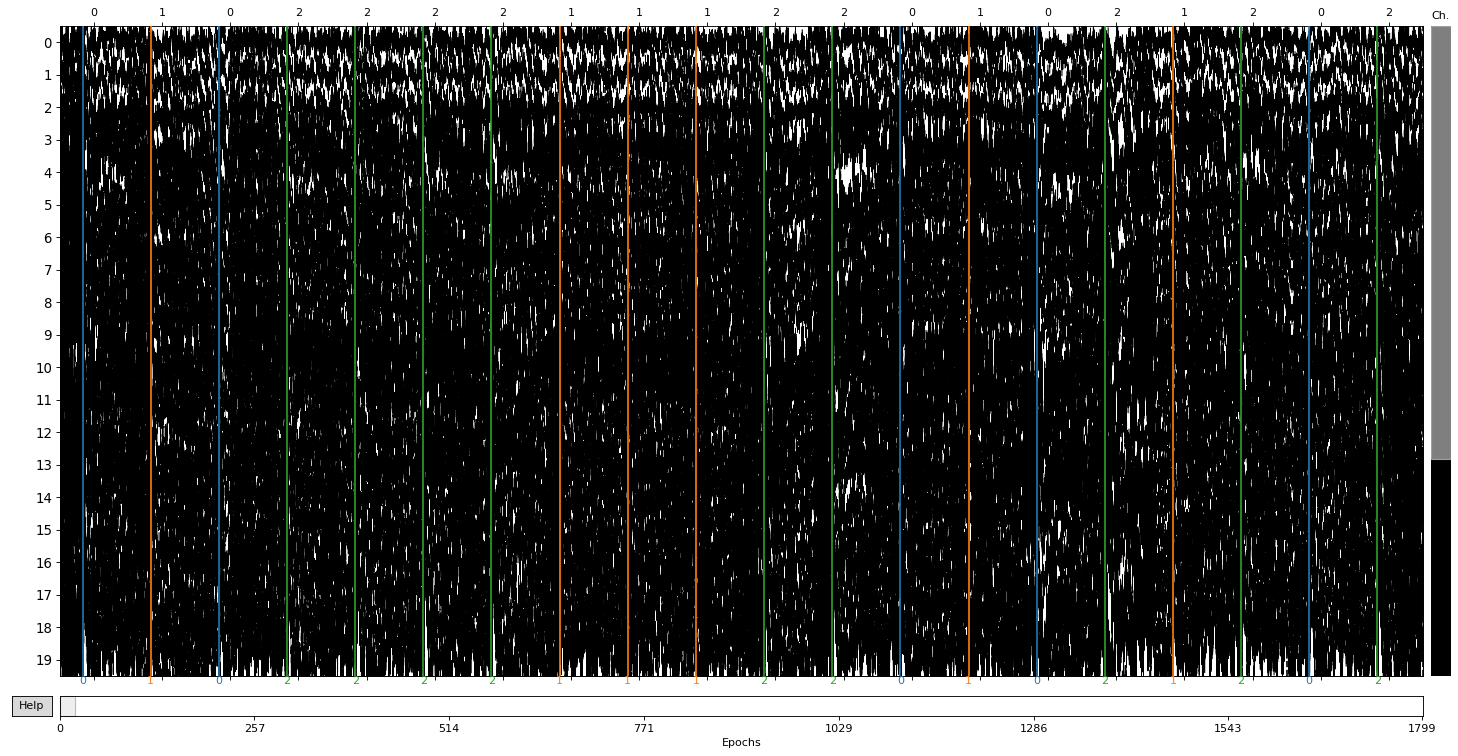

Loading data for 20 events and 3751 original time points ...
Loading data for 20 events and 3751 original time points ...
Loading data for 20 events and 3751 original time points ...
Loading data for 20 events and 3751 original time points ...
Loading data for 19 events and 3751 original time points ...
Loading data for 18 events and 3751 original time points ...
Loading data for 17 events and 3751 original time points ...
Loading data for 16 events and 3751 original time points ...
Loading data for 15 events and 3751 original time points ...
Loading data for 14 events and 3751 original time points ...
Loading data for 13 events and 3751 original time points ...
Loading data for 12 events and 3751 original time points ...
Loading data for 11 events and 3751 original time points ...
Loading data for 10 events and 3751 original time points ...
Loading data for 9 events and 3751 original time points ...
Loading data for 8 events and 3751 original time points ...
Loading data for 7 events 

In [17]:
ch_epochs.plot(scalings=scalings, n_epochs=20, n_channels=20, events=mne_all_events, event_id=event_id_dict)

Get bad epochs list?

In [19]:
epoch_good = [False if x == ['USER'] else True for x in ch_epochs.drop_log]
print(len(epoch_good))
# print(epoch_good)

1680


In [20]:
if 'good' not in stim_log.columns and len(epoch_good) == len(stim_log):
    stim_log['good'] = epoch_good
stim_log = stim_log.drop('event_descriptor', axis=1)
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep,good
0,biphasic,20,0.0004,23.30240,23.30280,0,True
1,biphasic,50,0.0004,24.80280,24.80320,0,True
2,biphasic,80,0.0004,26.30321,26.30361,0,True
3,biphasic,20,0.0004,27.80362,27.80402,0,True
4,biphasic,50,0.0004,29.30403,29.30443,0,True
